In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory



In [4]:
#Load the data using pandas : Create a DataFrame named df, that contains the training data 
df = pd.read_csv('BBCNewsTrain.csv')
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [5]:
df['category_id'] = df['Category'].factorize()[0]

#View first 10 entries of category_id, as a sanity check
df['category_id'][0:10]
df.head(10)


,ArticleId,Text,Category,category_id
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,0
5,1582,howard truanted to play snooker conservative...,politics,2
6,651,wales silent on grand slam talk rhys williams ...,sport,3
7,1797,french honour for director parker british film...,entertainment,4
8,2034,car giant hit by mercedes slump a slump in pro...,business,0
9,1866,fockers fuel festive film chart comedy meet th...,entertainment,4


In [6]:
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_id_df


,Category,category_id
0,business,0
3,tech,1
5,politics,2
6,sport,3
7,entertainment,4


In [7]:
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
id_to_category

{0: 'business', 1: 'tech', 2: 'politics', 3: 'sport', 4: 'entertainment'}

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Text).toarray() # Remaps the words in the 1490 articles in the text column of 
                                                  # data frame into features (superset of words) with an importance assigned 
                                                  # based on each words frequency in the document and across documents

labels = df.category_id                           # represents the category of each of the 1490 articles

features.shape # How many features are there ? 



(1490, 9927)

In [9]:
from sklearn.feature_selection import chi2
N = 3  # We are going to look for top 3 categories

#For each category, find words that are highly corelated to it
for Category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)                   # Do chi2 analyses of all items in this category
  indices = np.argsort(features_chi2[0])                                  # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
  feature_names = np.array(tfidf.get_feature_names())[indices]            # Converts indices to feature names ( in increasing order of chi-squared stat values)
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]         # List of single word features ( in increasing order of chi-squared stat values)
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]          # List for two-word features ( in increasing order of chi-squared stat values)
  print("# '{}':".format(Category))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) # Print 3 unigrams with highest Chi squared stat
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) # Print 3 bigrams with highest Chi squared stat

# 'business':
  . Most correlated unigrams:
       . growth
       . bank
       . shares
  . Most correlated bigrams:
       . stock market
       . economic growth
       . analysts said
# 'entertainment':
  . Most correlated unigrams:
       . singer
       . actor
       . film
  . Most correlated bigrams:
       . won best
       . los angeles
       . box office
# 'politics':
  . Most correlated unigrams:
       . blair
       . election
       . labour
  . Most correlated bigrams:
       . prime minister
       . tony blair
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . match
       . coach
       . cup
  . Most correlated bigrams:
       . grand slam
       . champions league
       . australian open
# 'tech':
  . Most correlated unigrams:
       . technology
       . software
       . users
  . Most correlated bigrams:
       . anti virus
       . mobile phones
       . mobile phone


In [10]:
from sklearn.manifold import TSNE

# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)          # Randomly select 30 % of samples
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices]) # Array of all projected features of 30% of Randomly chosen samples 
projected_features.shape

(447, 2)

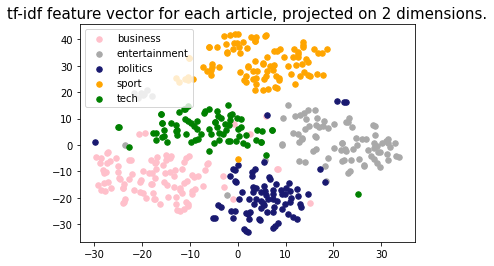

In [11]:
my_id = 0 # Select a category_id
projected_features[(labels[indices] == my_id).values]

colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']

# Find points belonging to each category and plot them
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
plt.legend()

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=100, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=30),
    SGDClassifier(loss="modified_huber", penalty="l2", max_iter=5),
    LinearSVC(random_state=0, tol=1e-5),
]


In [31]:
CV = 5  # Cross Validate with 5 different folds of 20% data ( 80-20 split with 5 folds )
#Create a data frame that will store the results for all 5 trials of the 3 different models
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = [] # Initially all entries are empty


In [32]:


#For each Algorithm 
for model in models:
  model_name = model.__class__.__name__
  # create 5 models with different 20% test sets, and store their accuracies
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  # Append all 5 accuracies into the entries list ( after all 3 models are run, there will be 3x5 = 15 entries)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))



/home/xavient/Desktop/manoj/python/37_globalenv/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/xavient/Desktop/manoj/python/37_globalenv/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/xavient/Desktop/manoj/python/37_globalenv/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/xavient/Desktop/manoj/python/37_globalenv/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached

In [33]:
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

<AxesSubplot:xlabel='model_name', ylabel='accuracy'>

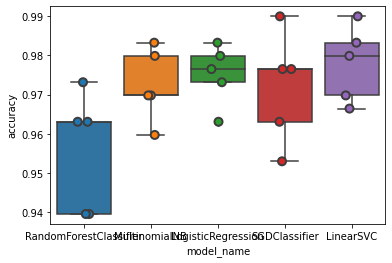

In [38]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

In [39]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.977852
LogisticRegression        0.975168
MultinomialNB             0.972483
RandomForestClassifier    0.955705
SGDClassifier             0.971812
Name: accuracy, dtype: float64

In [40]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.939597
1,RandomForestClassifier,1,0.939597
2,RandomForestClassifier,2,0.973154
3,RandomForestClassifier,3,0.963087
4,RandomForestClassifier,4,0.963087
5,MultinomialNB,0,0.969799
6,MultinomialNB,1,0.959732
7,MultinomialNB,2,0.983221
8,MultinomialNB,3,0.979866
9,MultinomialNB,4,0.969799


In [20]:
from sklearn.model_selection import train_test_split

model = LogisticRegression(random_state=0)

#Split Data 
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=42)

#Train Algorithm
model.fit(X_train, y_train)

# Make Predictions
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

In [38]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9796747967479674

Text(0.5, 15.0, 'Predicted')

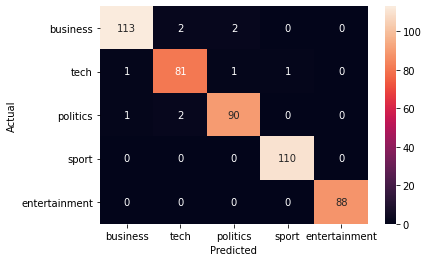

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [22]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 2:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]]['Text'])
      print('')

'business' predicted as 'tech' : 2 examples.


1384    brussels raps mobile call charges the european...
664     orange colour clash set for court a row over t...
Name: Text, dtype: object


'politics' predicted as 'tech' : 2 examples.


1415    mps issued with blackberry threat mps will be ...
643     mps issued with blackberry threat mps will be ...
Name: Text, dtype: object


'business' predicted as 'politics' : 2 examples.


1309    saudi ministry to employ women women will be e...
691     salary scandal in cameroon cameroon says wides...
Name: Text, dtype: object

In [23]:


from sklearn.feature_selection import chi2

N = 5
for Category, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])   # This time using the model co-eficients / weights
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Category))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))



# 'business':
  . Top unigrams:
       . firm
       . bank
       . shares
       . company
       . market
  . Top bigrams:
       . chief executive
       . stock market
       . economic growth
       . analysts said
       . stock exchange
# 'entertainment':
  . Top unigrams:
       . film
       . band
       . music
       . singer
       . actor
  . Top bigrams:
       . box office
       . los angeles
       . big brother
       . film maker
       . named best
# 'politics':
  . Top unigrams:
       . labour
       . election
       . government
       . mr
       . blair
  . Top bigrams:
       . mr blair
       . prime minister
       . general election
       . tony blair
       . mr brown
# 'sport':
  . Top unigrams:
       . win
       . match
       . game
       . coach
       . season
  . Top bigrams:
       . year old
       . australian open
       . champions league
       . grand slam
       . world number
# 'tech':
  . Top unigrams:
       . computer
       . soft

In [24]:
texts = ["Hooli stock price soared after a dip in PiedPiper revenue growth.",
         "Captain Tsubasa scores a magnificent goal for the Japanese team.",
         "Merryweather mercenaries are sent on another mission, as government oversight groups call for new sanctions.",
         "Beyoncé releases a new album, tops the charts in all of south-east Asia!",
         "You won't guess what the latest data in tech analysis is!"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"Hooli stock price soared after a dip in PiedPiper revenue growth."
  - Predicted as: 'business'

"Captain Tsubasa scores a magnificent goal for the Japanese team."
  - Predicted as: 'sport'

"Merryweather mercenaries are sent on another mission, as government oversight groups call for new sanctions."
  - Predicted as: 'politics'

"Beyoncé releases a new album, tops the charts in all of south-east Asia!"
  - Predicted as: 'entertainment'

"You won't guess what the latest data in tech analysis is!"
  - Predicted as: 'tech'

